## Setup & Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression as SklearnLR
import time

np.random.seed(42)

## 1. Load Dataset

In [3]:
import kagglehub

path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + "/dataset.csv")

print(f"Dataset shape: {df.shape}")
df.head()

/Users/kiragrudinina/Desktop/A_CDI_Roadmap/craftai_prep/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 2. Feature Selection

In [4]:
# Select 9 audio features
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'valence', 
            'tempo', 'duration_ms']

X = df[features].values
y = df['popularity'].values

print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")

Feature matrix: (114000, 9)
Target vector: (114000,)


## 3. Correlations

Let's check how features relate to popularity:

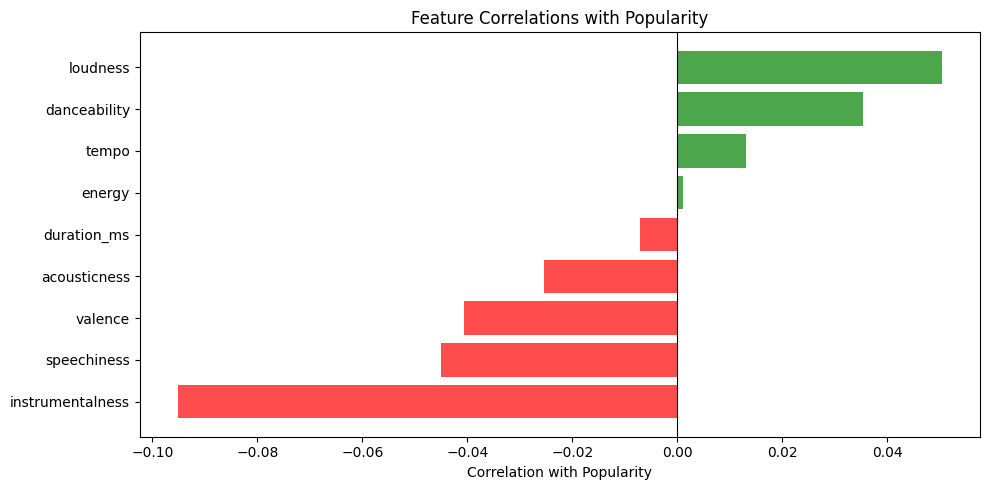

All correlations < 0.1 (very weak!)
This means audio features alone don't predict popularity well.
Popularity depends more on artist fame, marketing, and virality.


In [6]:
# Feature correlations with popularity
correlations = df[features].corrwith(df['popularity']).sort_values()

plt.figure(figsize=(10, 5))
colors = ['red' if x < 0 else 'green' for x in correlations]
plt.barh(correlations.index, correlations.values, color=colors, alpha=0.7)
plt.xlabel('Correlation with Popularity')
plt.title('Feature Correlations with Popularity')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

print("All correlations < 0.1 (very weak!)")
print("This means audio features alone don't predict popularity well.")
print("Popularity depends more on artist fame, marketing, and virality.")

## 4. Linear Regression Class (From Scratch)

In [8]:
class LinearRegression:
    """
    Linear Regression with Gradient Descent.
    
    Parameters:

    learning_rate : float
        Step size for gradient descent
    n_iters : int
        Number of training iterations
    """
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iters):
            # Predictions
            y_pred = np.dot(X, self.weights) + self.bias
            
            # Gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # Update
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Track cost
            cost = np.mean((y_pred - y) ** 2)
            self.cost_history.append(cost)
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

## 5. Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} songs")
print(f"Test set: {X_test.shape[0]:,} songs")

Training set: 91,200 songs
Test set: 22,800 songs


## 6. Training WITHOUT Scaling (The Problem)

Let's see what happens when we ignore the scale differences:
- `danceability`: 0 to 1
- `tempo`: 0 to 243
- `duration_ms`: 0 to 5,237,295

**Features span 6 orders of magnitude!**

In [10]:
print("Training WITHOUT scaling...\n")

model_unscaled = LinearRegression(learning_rate=0.01, n_iters=1000)
model_unscaled.fit(X_train, y_train)

print(f"Final cost: {model_unscaled.cost_history[-1]}")
print(f"First 10 costs: {model_unscaled.cost_history[:10]}")

Training WITHOUT scaling...



/var/folders/_q/tpskwvrs60g6t434pxt8zs640000gn/T/ipykernel_12595/2735299943.py:37: RuntimeWarning: overflow encountered in square
  cost = np.mean((y_pred - y) ** 2)
/var/folders/_q/tpskwvrs60g6t434pxt8zs640000gn/T/ipykernel_12595/2735299943.py:33: RuntimeWarning: invalid value encountered in subtract
  self.weights -= self.learning_rate * dw


Final cost: nan
First 10 costs: [np.float64(1606.1829166666666), np.float64(3.645439663940914e+20), np.float64(1.4764643918780423e+38), np.float64(5.979929175750349e+55), np.float64(2.4219719177584788e+73), np.float64(9.809393720243703e+90), np.float64(3.972969482148742e+108), np.float64(1.6091194783537688e+126), np.float64(6.5172045928154e+143), np.float64(2.6395775003648087e+161)]


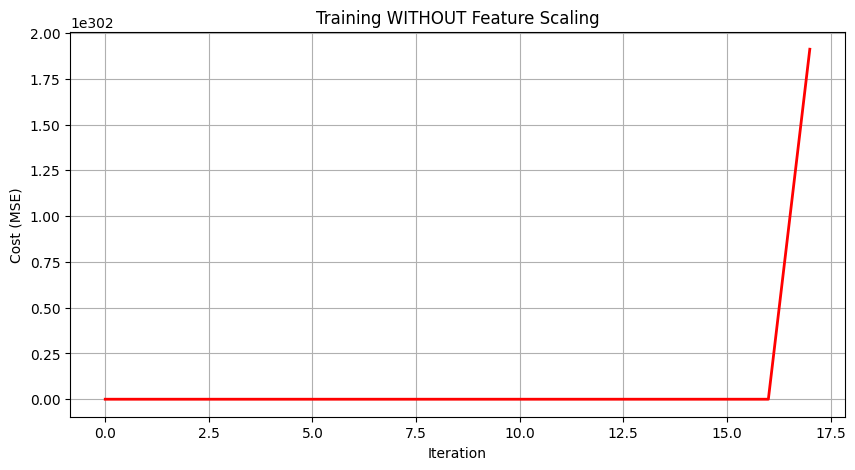


Model exploded after 18 iterations!

Why? Gradient for duration_ms is HUGE (range: 5+ million)
→ Takes massive steps → predictions explode → NaN


In [12]:
# Plot the explosion
plt.figure(figsize=(10, 5))
valid_costs = [c for c in model_unscaled.cost_history[:20] if not np.isnan(c) and not np.isinf(c)]
plt.plot(range(len(valid_costs)), valid_costs, linewidth=2, color='red')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Training WITHOUT Feature Scaling')
plt.grid(True)
plt.show()

print(f"\nModel exploded after {len(valid_costs)} iterations!")
print("\nWhy? Gradient for duration_ms is HUGE (range: 5+ million)")
print("→ Takes massive steps → predictions explode → NaN")

## 7. The Fix: Feature Scaling

**Standardization (Z-score normalization):**

$$x_{\text{scaled}} = \frac{x - \mu}{\sigma}$$

Where:
- μ = mean of feature
- σ = standard deviation

**Result:** All features have mean ≈ 0, std ≈ 1

### Critical: Data Leakage Prevention

**WRONG:**
```python
scaler.fit(X_all)  # Sees test data!
X_train, X_test = split(X_all)
```

**CORRECT:**
```python
X_train, X_test = split(X)
scaler.fit(X_train)  # Only train data!
X_test = scaler.transform(X_test)  # Use same scaler
```

In [14]:
# Fit scaler on training data ONLY
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler!

print("After standardization:")
print(f"Mean: {X_train_scaled.mean(axis=0)[:3].round(10)}")  
print(f"Std:  {X_train_scaled.std(axis=0)[:3]}")
print("\nAll features centered at 0, scaled to 1")

After standardization:
Mean: [ 0. -0.  0.]
Std:  [1. 1. 1.]

All features centered at 0, scaled to 1


## 8. Training WITH Scaling (The Solution)

In [15]:
print("Training WITH scaling...\n")

model_scaled = LinearRegression(learning_rate=0.01, n_iters=1000)
model_scaled.fit(X_train_scaled, y_train)

print(f"Final cost: {model_scaled.cost_history[-1]:.2f}")
print(f"First 10 costs: {[f'{c:.2f}' for c in model_scaled.cost_history[:10]]}")
print("\nSmooth convergence!")

Training WITH scaling...

Final cost: 487.07
First 10 costs: ['1606.18', '1583.96', '1562.19', '1540.85', '1519.93', '1499.43', '1479.34', '1459.65', '1440.35', '1421.43']

Smooth convergence!


## 9. Comparison: With vs Without Scaling

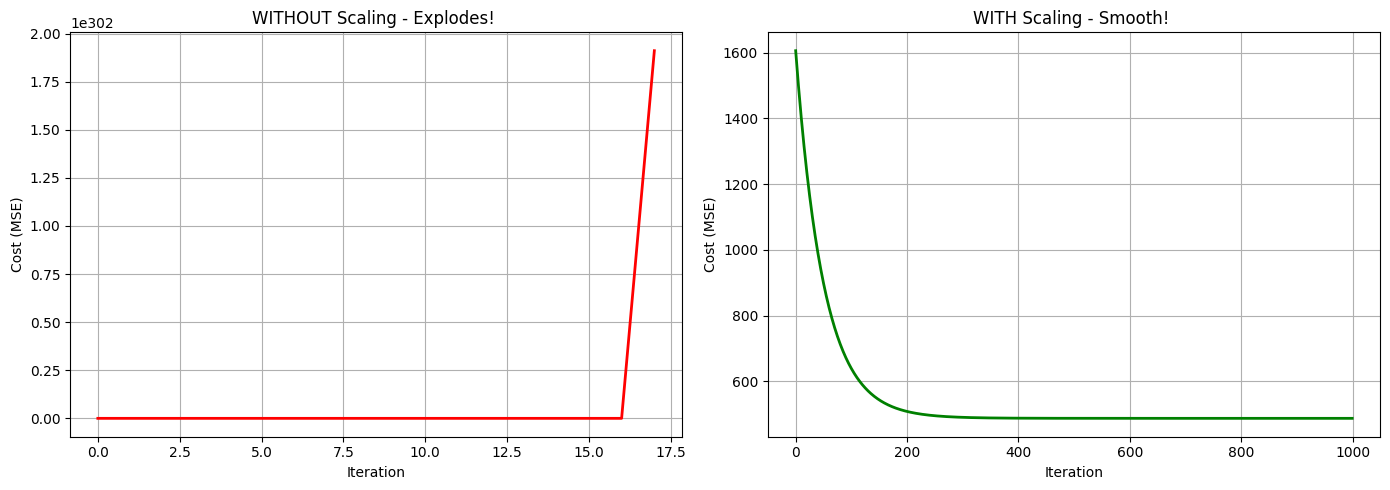

Key Takeaway:
Same code, same learning rate, only difference: FEATURE SCALING
Without: explosion → NaN
With: smooth convergence → working model


In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Without scaling
valid_costs = [c for c in model_unscaled.cost_history[:20] if not np.isnan(c) and not np.isinf(c)]
ax1.plot(range(len(valid_costs)), valid_costs, linewidth=2, color='red')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cost (MSE)')
ax1.set_title('WITHOUT Scaling - Explodes! ')
ax1.grid(True)

# With scaling
ax2.plot(model_scaled.cost_history, linewidth=2, color='green')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cost (MSE)')
ax2.set_title('WITH Scaling - Smooth! ')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Key Takeaway:")
print("Same code, same learning rate, only difference: FEATURE SCALING")
print("Without: explosion → NaN")
print("With: smooth convergence → working model")

## 10. Model Evaluation

In [19]:
# Predictions on scaled test data
y_pred = model_scaled.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:\n")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f} popularity points")
print(f"R²:   {r2:.3f}")

print("\nInterpretation:")
print(f"- RMSE = {rmse:.2f}: Average error is ~{rmse:.0f} popularity points")
print(f"- R² = {r2:.3f}: Model explains {r2*100:.1f}% of variance")

print("\n R² = 0.02 means audio features explain only 2% of popularity.")

Evaluation Metrics:

MSE:  483.51
RMSE: 21.99 popularity points
R²:   0.020

Interpretation:
- RMSE = 21.99: Average error is ~22 popularity points
- R² = 0.020: Model explains 2.0% of variance

 R² = 0.02 means audio features explain only 2% of popularity.


## 11. Validation: Compare with sklearn

In [20]:
# Train sklearn model
sklearn_model = SklearnLR()
sklearn_model.fit(X_train_scaled, y_train)
y_pred_sklearn = sklearn_model.predict(X_test_scaled)

sklearn_r2 = r2_score(y_test, y_pred_sklearn)

print("Comparing Our Implementation vs sklearn:\n")
print(f"Our R²:     {r2:.6f}")
print(f"sklearn R²: {sklearn_r2:.6f}")
print(f"Difference: {abs(r2 - sklearn_r2):.6f}")

print("\nAlmost identical! Our implementation is correct.")

Comparing Our Implementation vs sklearn:

Our R²:     0.020205
sklearn R²: 0.020210
Difference: 0.000005

Almost identical! Our implementation is correct.


---

## Summary

### What We Learned:

1. **Feature scaling is critical**
   - Without: model explodes (NaN)
   - With: smooth convergence
   - Always scale when features have different ranges!

2. **Data leakage prevention**
   - Fit scaler on train only
   - Test set = "the future"

3. **Evaluation metrics**
   - MSE: hard to interpret
   - RMSE: in same units as target
   - R²: proportion of variance explained

4. **Realistic expectations**
   - R² = 0.02 is not a failure
   - Audio features alone don't predict popularity
   - Most variance from artist fame & marketing

5. **Our implementation works**
   - Matches sklearn perfectly
   - Algorithm is correct
---

### Key Takeaway:

**Good code + weak data = weak predictions.**

That's ML, not a mistake!

---

**Next:** Logistic Regression for classification problems 